In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(364416, 828)
(364416, 1)
validation
(50712, 828)
(50712, 1)
test
(49296, 828)
(49296, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 55s - loss: 0.1389 - STD: 1.2123e-04 - MAE: 0.3593

 4/37 [==>...........................] - ETA: 1s - loss: 0.0477 - STD: 4.1555e-04 - MAE: 0.1679 

 5/37 [===>..........................] - ETA: 1s - loss: 0.0422 - STD: 3.7719e-04 - MAE: 0.1561

 6/37 [===>..........................] - ETA: 2s - loss: 0.0392 - STD: 3.3906e-04 - MAE: 0.1506

 7/37 [====>.........................] - ETA: 2s - loss: 0.0375 - STD: 3.0587e-04 - MAE: 0.1481

 8/37 [=====>........................] - ETA: 2s - loss: 0.0363 - STD: 2.7768e-04 - MAE: 0.1464

 9/37 [======>.......................] - ETA: 2s - loss: 0.0354 - STD: 2.5407e-04 - MAE: 0.1454

10/37 [=======>......................] - ETA: 2s - loss: 0.0347 - STD: 2.3407e-04 - MAE: 0.1446

11/37 [=======>......................] - ETA: 2s - loss: 0.0340 - STD: 2.1701e-04 - MAE: 0.1437

12/37 [========>.....................] - ETA: 2s - loss: 0.0334 - STD: 2.0241e-04 - MAE: 0.1426

13/37 [=========>....................] - ETA: 2s - loss: 0.0328 - STD: 1.8981e-04 - MAE: 0.1415

14/37 [==========>...................] - ETA: 2s - loss: 0.0322 - STD: 1.7888e-04 - MAE: 0.1401

15/37 [===========>..................] - ETA: 2s - loss: 0.0315 - STD: 1.6947e-04 - MAE: 0.1384

16/37 [===========>..................] - ETA: 1s - loss: 0.0308 - STD: 1.6139e-04 - MAE: 0.1365

17/37 [============>.................] - ETA: 1s - loss: 0.0300 - STD: 1.5448e-04 - MAE: 0.1343

18/37 [=============>................] - ETA: 1s - loss: 0.0292 - STD: 1.4867e-04 - MAE: 0.1319

19/37 [==============>...............] - ETA: 1s - loss: 0.0284 - STD: 1.4388e-04 - MAE: 0.1294

20/37 [===============>..............] - ETA: 1s - loss: 0.0276 - STD: 1.3991e-04 - MAE: 0.1268

21/37 [================>.............] - ETA: 1s - loss: 0.0267 - STD: 1.3658e-04 - MAE: 0.1243

22/37 [================>.............] - ETA: 1s - loss: 0.0260 - STD: 1.3375e-04 - MAE: 0.1222

23/37 [=================>............] - ETA: 1s - loss: 0.0253 - STD: 1.3127e-04 - MAE: 0.1204

24/37 [==================>...........] - ETA: 1s - loss: 0.0247 - STD: 1.2902e-04 - MAE: 0.1190

25/37 [===================>..........] - ETA: 1s - loss: 0.0244 - STD: 1.2688e-04 - MAE: 0.1179

28/37 [=====================>........] - ETA: 1s - loss: 0.0232 - STD: 1.2053e-04 - MAE: 0.1157

29/37 [======================>.......] - ETA: 0s - loss: 0.0228 - STD: 1.1844e-04 - MAE: 0.1150

30/37 [=======================>......] - ETA: 0s - loss: 0.0224 - STD: 1.1634e-04 - MAE: 0.1142

31/37 [========================>.....] - ETA: 0s - loss: 0.0220 - STD: 1.1430e-04 - MAE: 0.1132

32/37 [========================>.....] - ETA: 0s - loss: 0.0217 - STD: 1.1231e-04 - MAE: 0.1122

33/37 [=========================>....] - ETA: 0s - loss: 0.0213 - STD: 1.1040e-04 - MAE: 0.1112

34/37 [==========================>...] - ETA: 0s - loss: 0.0209 - STD: 1.0858e-04 - MAE: 0.1102

35/37 [===========================>..] - ETA: 0s - loss: 0.0206 - STD: 1.0687e-04 - MAE: 0.1093

36/37 [============================>.] - ETA: 0s - loss: 0.0203 - STD: 1.0524e-04 - MAE: 0.1083

37/37 [==============================] - ETA: 0s - loss: 0.0201 - STD: 1.0371e-04 - MAE: 0.1074

37/37 [==============================] - 6s 131ms/step - loss: 0.0201 - STD: 1.0371e-04 - MAE: 0.1074 - val_loss: 0.0091 - val_STD: 3.2661e-05 - val_MAE: 0.0697


Epoch 2/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0104 - STD: 4.8877e-05 - MAE: 0.0751

 2/37 [>.............................] - ETA: 3s - loss: 0.0107 - STD: 4.9131e-05 - MAE: 0.0763

 3/37 [=>............................] - ETA: 3s - loss: 0.0106 - STD: 4.9661e-05 - MAE: 0.0761

 4/37 [==>...........................] - ETA: 3s - loss: 0.0106 - STD: 5.0090e-05 - MAE: 0.0760

 5/37 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 5.0716e-05 - MAE: 0.0761

 6/37 [===>..........................] - ETA: 3s - loss: 0.0106 - STD: 5.1273e-05 - MAE: 0.0760

 7/37 [====>.........................] - ETA: 3s - loss: 0.0105 - STD: 5.1937e-05 - MAE: 0.0759

 8/37 [=====>........................] - ETA: 3s - loss: 0.0104 - STD: 5.2618e-05 - MAE: 0.0758

 9/37 [======>.......................] - ETA: 3s - loss: 0.0103 - STD: 5.3442e-05 - MAE: 0.0759

10/37 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 5.4112e-05 - MAE: 0.0760

11/37 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 5.4852e-05 - MAE: 0.0762

12/37 [========>.....................] - ETA: 2s - loss: 0.0102 - STD: 5.5587e-05 - MAE: 0.0765

13/37 [=========>....................] - ETA: 2s - loss: 0.0102 - STD: 5.6360e-05 - MAE: 0.0767

14/37 [==========>...................] - ETA: 2s - loss: 0.0102 - STD: 5.7146e-05 - MAE: 0.0769

15/37 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 5.7938e-05 - MAE: 0.0772

16/37 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 5.8689e-05 - MAE: 0.0774

17/37 [============>.................] - ETA: 2s - loss: 0.0101 - STD: 5.9450e-05 - MAE: 0.0775

18/37 [=============>................] - ETA: 2s - loss: 0.0101 - STD: 6.0206e-05 - MAE: 0.0776

19/37 [==============>...............] - ETA: 1s - loss: 0.0101 - STD: 6.1047e-05 - MAE: 0.0778

20/37 [===============>..............] - ETA: 1s - loss: 0.0101 - STD: 6.1844e-05 - MAE: 0.0778

21/37 [================>.............] - ETA: 1s - loss: 0.0101 - STD: 6.2655e-05 - MAE: 0.0778

22/37 [================>.............] - ETA: 1s - loss: 0.0101 - STD: 6.3414e-05 - MAE: 0.0778

23/37 [=================>............] - ETA: 1s - loss: 0.0101 - STD: 6.4218e-05 - MAE: 0.0778

24/37 [==================>...........] - ETA: 1s - loss: 0.0101 - STD: 6.4997e-05 - MAE: 0.0777

25/37 [===================>..........] - ETA: 1s - loss: 0.0101 - STD: 6.5779e-05 - MAE: 0.0776

26/37 [====================>.........] - ETA: 1s - loss: 0.0101 - STD: 6.6603e-05 - MAE: 0.0776

27/37 [====================>.........] - ETA: 1s - loss: 0.0100 - STD: 6.7431e-05 - MAE: 0.0775

28/37 [=====================>........] - ETA: 0s - loss: 0.0100 - STD: 6.8258e-05 - MAE: 0.0775

29/37 [======================>.......] - ETA: 0s - loss: 0.0100 - STD: 6.9129e-05 - MAE: 0.0774

30/37 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 7.0022e-05 - MAE: 0.0774

31/37 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 7.0905e-05 - MAE: 0.0774

32/37 [========================>.....] - ETA: 0s - loss: 0.0100 - STD: 7.1812e-05 - MAE: 0.0774

34/37 [==========================>...] - ETA: 0s - loss: 0.0100 - STD: 7.3686e-05 - MAE: 0.0774

35/37 [===========================>..] - ETA: 0s - loss: 0.0100 - STD: 7.4712e-05 - MAE: 0.0774

36/37 [============================>.] - ETA: 0s - loss: 0.0100 - STD: 7.5762e-05 - MAE: 0.0774

37/37 [==============================] - ETA: 0s - loss: 0.0100 - STD: 7.6843e-05 - MAE: 0.0774

37/37 [==============================] - 4s 111ms/step - loss: 0.0100 - STD: 7.6843e-05 - MAE: 0.0774 - val_loss: 0.0085 - val_STD: 8.6640e-05 - val_MAE: 0.0764


Epoch 3/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0100 - STD: 1.2009e-04 - MAE: 0.0789

 2/37 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.2074e-04 - MAE: 0.0787

 3/37 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.2217e-04 - MAE: 0.0785

 4/37 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.2329e-04 - MAE: 0.0786

 5/37 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.2463e-04 - MAE: 0.0784

 6/37 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.2624e-04 - MAE: 0.0782

 7/37 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.2761e-04 - MAE: 0.0781

 8/37 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.2904e-04 - MAE: 0.0780

 9/37 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 1.3045e-04 - MAE: 0.0778

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.3197e-04 - MAE: 0.0777

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 1.3360e-04 - MAE: 0.0776

12/37 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 1.3528e-04 - MAE: 0.0776

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 1.3696e-04 - MAE: 0.0775

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 1.3863e-04 - MAE: 0.0774

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 1.4033e-04 - MAE: 0.0773

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 1.4212e-04 - MAE: 0.0773

17/37 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 1.4404e-04 - MAE: 0.0773

18/37 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 1.4617e-04 - MAE: 0.0774

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 1.4828e-04 - MAE: 0.0774

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 1.5041e-04 - MAE: 0.0773

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 1.5268e-04 - MAE: 0.0774

22/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 1.5493e-04 - MAE: 0.0774

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 1.5734e-04 - MAE: 0.0774

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 1.5965e-04 - MAE: 0.0775

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 1.6194e-04 - MAE: 0.0774

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 1.6456e-04 - MAE: 0.0774

27/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 1.6705e-04 - MAE: 0.0774

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 1.6969e-04 - MAE: 0.0774

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 1.7224e-04 - MAE: 0.0774

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 1.7487e-04 - MAE: 0.0774

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 1.7750e-04 - MAE: 0.0774

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 1.8022e-04 - MAE: 0.0773

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 1.8303e-04 - MAE: 0.0773

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 1.8913e-04 - MAE: 0.0773

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 1.9229e-04 - MAE: 0.0773

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 1.9555e-04 - MAE: 0.0773

37/37 [==============================] - 4s 109ms/step - loss: 0.0098 - STD: 1.9555e-04 - MAE: 0.0773 - val_loss: 0.0085 - val_STD: 2.3878e-04 - val_MAE: 0.0745


Epoch 4/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0098 - STD: 3.2444e-04 - MAE: 0.0769

 2/37 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 3.3034e-04 - MAE: 0.0770

 3/37 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.3524e-04 - MAE: 0.0771

 4/37 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.4097e-04 - MAE: 0.0772

 5/37 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.4600e-04 - MAE: 0.0772

 6/37 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.5201e-04 - MAE: 0.0772

 7/37 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 3.5745e-04 - MAE: 0.0772

 8/37 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 3.6410e-04 - MAE: 0.0772

 9/37 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 3.7029e-04 - MAE: 0.0773

10/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 3.7650e-04 - MAE: 0.0773

11/37 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 3.8348e-04 - MAE: 0.0774

12/37 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 3.9036e-04 - MAE: 0.0773

13/37 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 3.9758e-04 - MAE: 0.0773

14/37 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 4.0472e-04 - MAE: 0.0773

15/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 4.1208e-04 - MAE: 0.0773

16/37 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 4.1973e-04 - MAE: 0.0772

17/37 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 4.2811e-04 - MAE: 0.0773

18/37 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 4.3691e-04 - MAE: 0.0773

19/37 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 4.4589e-04 - MAE: 0.0772

20/37 [===============>..............] - ETA: 1s - loss: 0.0098 - STD: 4.5518e-04 - MAE: 0.0773

21/37 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 4.6411e-04 - MAE: 0.0772

23/37 [=================>............] - ETA: 1s - loss: 0.0098 - STD: 4.8414e-04 - MAE: 0.0772

24/37 [==================>...........] - ETA: 1s - loss: 0.0098 - STD: 4.9465e-04 - MAE: 0.0773

25/37 [===================>..........] - ETA: 1s - loss: 0.0098 - STD: 5.0509e-04 - MAE: 0.0773

26/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 5.1614e-04 - MAE: 0.0773

27/37 [====================>.........] - ETA: 1s - loss: 0.0098 - STD: 5.2749e-04 - MAE: 0.0773

28/37 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 5.3905e-04 - MAE: 0.0772

29/37 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 5.5127e-04 - MAE: 0.0772

30/37 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 5.6380e-04 - MAE: 0.0772

31/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 5.7691e-04 - MAE: 0.0772

32/37 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 5.9079e-04 - MAE: 0.0772

33/37 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 6.0461e-04 - MAE: 0.0772

34/37 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 6.1893e-04 - MAE: 0.0772

35/37 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 6.3420e-04 - MAE: 0.0772

36/37 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 6.5014e-04 - MAE: 0.0772

37/37 [==============================] - ETA: 0s - loss: 0.0098 - STD: 6.6645e-04 - MAE: 0.0772

37/37 [==============================] - 4s 112ms/step - loss: 0.0098 - STD: 6.6645e-04 - MAE: 0.0772 - val_loss: 0.0084 - val_STD: 9.6551e-04 - val_MAE: 0.0743


Epoch 5/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0096 - STD: 0.0013 - MAE: 0.0769

 2/37 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0770

 3/37 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0768

 4/37 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0771

 5/37 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0014 - MAE: 0.0769

 6/37 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0768

 7/37 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0768

 8/37 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0768

 9/37 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0768

10/37 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0769

11/37 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0769

12/37 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0769

13/37 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0768

14/37 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0769

15/37 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0769

16/37 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0769

17/37 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0769

18/37 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0768

19/37 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0769

20/37 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0768

21/37 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0768

22/37 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0768

23/37 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0024 - MAE: 0.0768

24/37 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0024 - MAE: 0.0767

25/37 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0025 - MAE: 0.0767

26/37 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0026 - MAE: 0.0767

27/37 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0027 - MAE: 0.0767

28/37 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0028 - MAE: 0.0766

29/37 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0029 - MAE: 0.0766

30/37 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0765

32/37 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0764

33/37 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0033 - MAE: 0.0764

34/37 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0034 - MAE: 0.0764

35/37 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0035 - MAE: 0.0763

36/37 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0036 - MAE: 0.0763

37/37 [==============================] - ETA: 0s - loss: 0.0095 - STD: 0.0038 - MAE: 0.0763

37/37 [==============================] - 4s 110ms/step - loss: 0.0095 - STD: 0.0038 - MAE: 0.0763 - val_loss: 0.0079 - val_STD: 0.0064 - val_MAE: 0.0716


Epoch 6/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0088 - MAE: 0.0743

 2/37 [>.............................] - ETA: 3s - loss: 0.0090 - STD: 0.0090 - MAE: 0.0741

 3/37 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0093 - MAE: 0.0740

 4/37 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.0096 - MAE: 0.0742

 5/37 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0098 - MAE: 0.0744

 6/37 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0101 - MAE: 0.0744

 7/37 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0104 - MAE: 0.0744

 8/37 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0107 - MAE: 0.0743

 9/37 [======>.......................] - ETA: 2s - loss: 0.0089 - STD: 0.0110 - MAE: 0.0742

10/37 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.0113 - MAE: 0.0741

11/37 [=======>......................] - ETA: 2s - loss: 0.0089 - STD: 0.0116 - MAE: 0.0740

12/37 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0119 - MAE: 0.0739

13/37 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0123 - MAE: 0.0739

14/37 [==========>...................] - ETA: 2s - loss: 0.0088 - STD: 0.0126 - MAE: 0.0739

15/37 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0130 - MAE: 0.0738

16/37 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0133 - MAE: 0.0738

17/37 [============>.................] - ETA: 2s - loss: 0.0088 - STD: 0.0137 - MAE: 0.0737

18/37 [=============>................] - ETA: 2s - loss: 0.0087 - STD: 0.0141 - MAE: 0.0736

19/37 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 0.0145 - MAE: 0.0735

20/37 [===============>..............] - ETA: 1s - loss: 0.0087 - STD: 0.0149 - MAE: 0.0734

21/37 [================>.............] - ETA: 1s - loss: 0.0087 - STD: 0.0153 - MAE: 0.0733

22/37 [================>.............] - ETA: 1s - loss: 0.0086 - STD: 0.0157 - MAE: 0.0732

23/37 [=================>............] - ETA: 1s - loss: 0.0086 - STD: 0.0161 - MAE: 0.0731

24/37 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0165 - MAE: 0.0730

25/37 [===================>..........] - ETA: 1s - loss: 0.0086 - STD: 0.0169 - MAE: 0.0729

26/37 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0173 - MAE: 0.0728

27/37 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0178 - MAE: 0.0727

28/37 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0182 - MAE: 0.0727

29/37 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0186 - MAE: 0.0726

30/37 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0190 - MAE: 0.0725

31/37 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0194 - MAE: 0.0724

32/37 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0198 - MAE: 0.0724

34/37 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.0207 - MAE: 0.0722

35/37 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.0211 - MAE: 0.0721

36/37 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0215 - MAE: 0.0720

37/37 [==============================] - ETA: 0s - loss: 0.0084 - STD: 0.0219 - MAE: 0.0720

37/37 [==============================] - 4s 111ms/step - loss: 0.0084 - STD: 0.0219 - MAE: 0.0720 - val_loss: 0.0068 - val_STD: 0.0268 - val_MAE: 0.0624


Epoch 7/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0079 - STD: 0.0371 - MAE: 0.0695

 2/37 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0375 - MAE: 0.0689

 3/37 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0379 - MAE: 0.0688

 4/37 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0382 - MAE: 0.0688

 5/37 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.0385 - MAE: 0.0688

 6/37 [===>..........................] - ETA: 3s - loss: 0.0077 - STD: 0.0387 - MAE: 0.0688

 7/37 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0390 - MAE: 0.0689

 8/37 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.0393 - MAE: 0.0689

 9/37 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0395 - MAE: 0.0688

10/37 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0397 - MAE: 0.0688

11/37 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0399 - MAE: 0.0688

12/37 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.0401 - MAE: 0.0687

14/37 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0404 - MAE: 0.0684

15/37 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0405 - MAE: 0.0684

16/37 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0406 - MAE: 0.0684

17/37 [============>.................] - ETA: 2s - loss: 0.0077 - STD: 0.0406 - MAE: 0.0683

18/37 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0407 - MAE: 0.0683

19/37 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0408 - MAE: 0.0683

20/37 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0408 - MAE: 0.0682

21/37 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0409 - MAE: 0.0682

22/37 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0409 - MAE: 0.0682

23/37 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0410 - MAE: 0.0682

24/37 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0411 - MAE: 0.0681

25/37 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0412 - MAE: 0.0680

26/37 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0412 - MAE: 0.0679

27/37 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0413 - MAE: 0.0679

28/37 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0414 - MAE: 0.0679

29/37 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.0414 - MAE: 0.0678

30/37 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.0415 - MAE: 0.0678

31/37 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0416 - MAE: 0.0678

32/37 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.0417 - MAE: 0.0677

33/37 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.0417 - MAE: 0.0677

34/37 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0418 - MAE: 0.0676

35/37 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0419 - MAE: 0.0676

36/37 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0419 - MAE: 0.0675

37/37 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0420 - MAE: 0.0675

37/37 [==============================] - 4s 111ms/step - loss: 0.0075 - STD: 0.0420 - MAE: 0.0675 - val_loss: 0.0064 - val_STD: 0.0306 - val_MAE: 0.0579


Epoch 8/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0074 - STD: 0.0433 - MAE: 0.0666

 2/37 [>.............................] - ETA: 3s - loss: 0.0073 - STD: 0.0432 - MAE: 0.0665

 3/37 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0434 - MAE: 0.0662

 4/37 [==>...........................] - ETA: 3s - loss: 0.0073 - STD: 0.0434 - MAE: 0.0663

 5/37 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0435 - MAE: 0.0663

 6/37 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0437 - MAE: 0.0662

 7/37 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0438 - MAE: 0.0662

 8/37 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0439 - MAE: 0.0662

 9/37 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0441 - MAE: 0.0660

10/37 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.0442 - MAE: 0.0660

11/37 [=======>......................] - ETA: 2s - loss: 0.0072 - STD: 0.0444 - MAE: 0.0659

12/37 [========>.....................] - ETA: 2s - loss: 0.0072 - STD: 0.0446 - MAE: 0.0658

13/37 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0447 - MAE: 0.0657

14/37 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0448 - MAE: 0.0656

15/37 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0449 - MAE: 0.0655

16/37 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0450 - MAE: 0.0654

17/37 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0451 - MAE: 0.0653

18/37 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0452 - MAE: 0.0653

19/37 [==============>...............] - ETA: 1s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0652

20/37 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0651

21/37 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0453 - MAE: 0.0650

23/37 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0455 - MAE: 0.0650

24/37 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0456 - MAE: 0.0649

25/37 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0456 - MAE: 0.0648

26/37 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0457 - MAE: 0.0647

27/37 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0458 - MAE: 0.0646

28/37 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0460 - MAE: 0.0645

29/37 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0461 - MAE: 0.0644

30/37 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0462 - MAE: 0.0643

31/37 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0464 - MAE: 0.0642

32/37 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0465 - MAE: 0.0641

33/37 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0465 - MAE: 0.0639

34/37 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0467 - MAE: 0.0639

35/37 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0469 - MAE: 0.0637

36/37 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0469 - MAE: 0.0636

37/37 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0471 - MAE: 0.0636

37/37 [==============================] - 4s 110ms/step - loss: 0.0067 - STD: 0.0471 - MAE: 0.0636 - val_loss: 0.0052 - val_STD: 0.0344 - val_MAE: 0.0525


Epoch 9/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0587

 2/37 [>.............................] - ETA: 3s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0587

 3/37 [=>............................] - ETA: 3s - loss: 0.0059 - STD: 0.0528 - MAE: 0.0594

 4/37 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0528 - MAE: 0.0591

 5/37 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0530 - MAE: 0.0588

 6/37 [===>..........................] - ETA: 3s - loss: 0.0059 - STD: 0.0537 - MAE: 0.0589

 7/37 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0541 - MAE: 0.0589

 8/37 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0544 - MAE: 0.0588

 9/37 [======>.......................] - ETA: 2s - loss: 0.0058 - STD: 0.0550 - MAE: 0.0589

10/37 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0551 - MAE: 0.0587

11/37 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0556 - MAE: 0.0587

12/37 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0558 - MAE: 0.0586

13/37 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0562 - MAE: 0.0585

14/37 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0565 - MAE: 0.0585

15/37 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0567 - MAE: 0.0584

16/37 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0584

17/37 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0583

18/37 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0582

19/37 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0583

20/37 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0574 - MAE: 0.0581

21/37 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0581

22/37 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0578 - MAE: 0.0581

23/37 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0578 - MAE: 0.0580

24/37 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0580

25/37 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0579

26/37 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0578

27/37 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0578

28/37 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0578

29/37 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0577

30/37 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0576

31/37 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0576

33/37 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0576

34/37 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0575

35/37 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0575

36/37 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

37/37 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

37/37 [==============================] - 4s 109ms/step - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574 - val_loss: 0.0044 - val_STD: 0.0452 - val_MAE: 0.0494


Epoch 10/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0570

 2/37 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0559

 4/37 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0555

 5/37 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0552

 6/37 [===>..........................] - ETA: 2s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0552

 7/37 [====>.........................] - ETA: 2s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0552

 8/37 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0623 - MAE: 0.0550

 9/37 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

10/37 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0552

11/37 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

12/37 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0552

13/37 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0551

14/37 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0549

15/37 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0549

16/37 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0548

17/37 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0548

18/37 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0547

19/37 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

20/37 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0547

21/37 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0546

22/37 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0545

23/37 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0545

24/37 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0545

25/37 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0545

26/37 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0639 - MAE: 0.0544

27/37 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0544

28/37 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0544

29/37 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0640 - MAE: 0.0543

30/37 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0544

31/37 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0543

32/37 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0543

33/37 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0542

34/37 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0643 - MAE: 0.0542

35/37 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0542

36/37 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0541

37/37 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0645 - MAE: 0.0541

37/37 [==============================] - 4s 110ms/step - loss: 0.0051 - STD: 0.0645 - MAE: 0.0541 - val_loss: 0.0040 - val_STD: 0.0491 - val_MAE: 0.0461


Epoch 11/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0530

 2/37 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0524

 3/37 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0524

 4/37 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0524

 5/37 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0521

 6/37 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0666 - MAE: 0.0522

 7/37 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0522

 8/37 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0663 - MAE: 0.0521

 9/37 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0523

10/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0522

11/37 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0522

12/37 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0521

13/37 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0520

14/37 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0519

15/37 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0521

16/37 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0520

18/37 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0519

19/37 [==============>...............] - ETA: 1s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0518

20/37 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0519

21/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0518

22/37 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0517

23/37 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0517

24/37 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0517

25/37 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0518

26/37 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0518

27/37 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0518

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0679 - MAE: 0.0519

29/37 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0675 - MAE: 0.0519

30/37 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0677 - MAE: 0.0520

31/37 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0520

32/37 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0676 - MAE: 0.0519

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0678 - MAE: 0.0519

35/37 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0519

36/37 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0519

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519

37/37 [==============================] - 4s 110ms/step - loss: 0.0047 - STD: 0.0677 - MAE: 0.0519 - val_loss: 0.0042 - val_STD: 0.0455 - val_MAE: 0.0449


Epoch 12/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0638 - MAE: 0.0492

 2/37 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0671 - MAE: 0.0504

 3/37 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0510

 4/37 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0506

 5/37 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0507

 6/37 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0505

 7/37 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0503

 8/37 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0502

 9/37 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0502

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

11/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0691 - MAE: 0.0501

12/37 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0500

13/37 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0693 - MAE: 0.0500

14/37 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0500

15/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0499

16/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0499

17/37 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0499

18/37 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0499

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0499

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0499

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

22/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

23/37 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

24/37 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

25/37 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

26/37 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

27/37 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

29/37 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0497

30/37 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0701 - MAE: 0.0498

33/37 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0498

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

35/37 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0498

36/37 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0497

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0497

37/37 [==============================] - 4s 110ms/step - loss: 0.0044 - STD: 0.0704 - MAE: 0.0497 - val_loss: 0.0040 - val_STD: 0.0496 - val_MAE: 0.0435


Epoch 13/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0484

 2/37 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

 3/37 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0689 - MAE: 0.0500

 4/37 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0506

 5/37 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0698 - MAE: 0.0501

 6/37 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0502

 7/37 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0500

 8/37 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0703 - MAE: 0.0498

 9/37 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0499

10/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0497

11/37 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0499

12/37 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0498

13/37 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0497

14/37 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0498

15/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

16/37 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0496

17/37 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0495

18/37 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0494

19/37 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0495

20/37 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0494

21/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0494

22/37 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0494

23/37 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0493

24/37 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0493

25/37 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0493

26/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0492

27/37 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0493

28/37 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0492

29/37 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0492

30/37 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0491

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0491

32/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0491

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0490

35/37 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0716 - MAE: 0.0490

36/37 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0489

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0489

37/37 [==============================] - 4s 109ms/step - loss: 0.0043 - STD: 0.0717 - MAE: 0.0489 - val_loss: 0.0035 - val_STD: 0.0553 - val_MAE: 0.0413


Epoch 14/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0479

 2/37 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0475

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0475

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0474

 5/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

 6/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0478

 7/37 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0478

 8/37 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0482

 9/37 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0481

10/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0482

11/37 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

12/37 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

13/37 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

14/37 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

15/37 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

16/37 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

17/37 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0481

18/37 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0481

19/37 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

20/37 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

21/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0482

22/37 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0482

23/37 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0481

24/37 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

25/37 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0481

26/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

27/37 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0481

29/37 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

30/37 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0481

32/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0481

33/37 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0480

35/37 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

36/37 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0480

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

37/37 [==============================] - 4s 111ms/step - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480 - val_loss: 0.0033 - val_STD: 0.0603 - val_MAE: 0.0410


Epoch 15/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0484

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0468

 3/37 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0463

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0472

 5/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0726 - MAE: 0.0473

 6/37 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0476

 7/37 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

 8/37 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0474

 9/37 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

10/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0475

11/37 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0474

12/37 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0475

13/37 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0474

14/37 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0476

15/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0475

16/37 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0474

17/37 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0475

19/37 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0475

20/37 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0475

21/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0475

22/37 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

23/37 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0476

24/37 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0475

25/37 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0476

26/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0476

27/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0476

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0476

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0476

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0477

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0476

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0476

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0476

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0477

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0477

37/37 [==============================] - 4s 110ms/step - loss: 0.0041 - STD: 0.0735 - MAE: 0.0477 - val_loss: 0.0033 - val_STD: 0.0586 - val_MAE: 0.0402


Epoch 16/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0465

 2/37 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0794 - MAE: 0.0500

 3/37 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0500

 4/37 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0491

 5/37 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0517

 6/37 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0718 - MAE: 0.0528

 7/37 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0525

 8/37 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0722 - MAE: 0.0549

 9/37 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0711 - MAE: 0.0540

10/37 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0693 - MAE: 0.0541

11/37 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0691 - MAE: 0.0535

13/37 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0537

14/37 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0535

15/37 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0680 - MAE: 0.0532

16/37 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0536

17/37 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0533

18/37 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0531

19/37 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0528

20/37 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528

21/37 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0528

22/37 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0526

23/37 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0524

24/37 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0522

25/37 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0685 - MAE: 0.0522

26/37 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0520

27/37 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519

28/37 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0517

29/37 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0687 - MAE: 0.0516

30/37 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0515

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0513

32/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0512

33/37 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0511

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0694 - MAE: 0.0510

35/37 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0508

36/37 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0695 - MAE: 0.0507

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0697 - MAE: 0.0506

37/37 [==============================] - 4s 110ms/step - loss: 0.0046 - STD: 0.0697 - MAE: 0.0506 - val_loss: 0.0033 - val_STD: 0.0597 - val_MAE: 0.0406


Epoch 17/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0477

 2/37 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0474

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0468

 4/37 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0469

 5/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0472

 6/37 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0469

 7/37 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

 8/37 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0469

 9/37 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0470

10/37 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0469

11/37 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0469

12/37 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0469

13/37 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0469

14/37 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0468

15/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0468

16/37 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0468

17/37 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0468

18/37 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0468

19/37 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0467

20/37 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0467

21/37 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0467

23/37 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0466

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0466

25/37 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

26/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0465

27/37 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0465

29/37 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0465

30/37 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0464

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0464

32/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

33/37 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0464

35/37 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

36/37 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

37/37 [==============================] - 4s 108ms/step - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463 - val_loss: 0.0032 - val_STD: 0.0605 - val_MAE: 0.0397


Epoch 18/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0463

 2/37 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

 3/37 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0457

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0459

 5/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

 6/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0458

 7/37 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0457

 8/37 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

 9/37 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

10/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

11/37 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

12/37 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

13/37 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0459

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0457

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

17/37 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

18/37 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0457

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0458

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

27/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0458

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0459

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0459

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

37/37 [==============================] - 4s 109ms/step - loss: 0.0038 - STD: 0.0762 - MAE: 0.0457 - val_loss: 0.0034 - val_STD: 0.0585 - val_MAE: 0.0395


Epoch 19/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0450

 2/37 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0460

 3/37 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

 5/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

 6/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

 7/37 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0454

 8/37 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0453

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0453

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0452

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0452

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

15/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

16/37 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0452

17/37 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

18/37 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

19/37 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

20/37 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

24/37 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

25/37 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

26/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

27/37 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

29/37 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0454

30/37 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

32/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

33/37 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

35/37 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

36/37 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

37/37 [==============================] - 4s 103ms/step - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455 - val_loss: 0.0032 - val_STD: 0.0603 - val_MAE: 0.0390


Epoch 20/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0441

 2/37 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

 3/37 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

 4/37 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0449

 5/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0448

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0448

 8/37 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

37/37 [==============================] - 4s 98ms/step - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450 - val_loss: 0.0031 - val_STD: 0.0634 - val_MAE: 0.0390


Epoch 21/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0459

 2/37 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0451

 3/37 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

 4/37 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

 5/37 [===>..........................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0452

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452

 8/37 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0452

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0449

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

37/37 [==============================] - 4s 96ms/step - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0386


Epoch 22/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0445

 2/37 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0443

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0447

 4/37 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

 5/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 6/37 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

 7/37 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0447

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0448

15/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

16/37 [===========>..................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

37/37 [==============================] - 4s 96ms/step - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0649 - val_MAE: 0.0387


Epoch 23/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0455

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0448

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0447

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0444

 6/37 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0445

 7/37 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0444

 8/37 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0445

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

37/37 [==============================] - 4s 99ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0382


Epoch 24/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0439

 2/37 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0436

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0439

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

 6/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0442

 7/37 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0441

 8/37 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

 9/37 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0442

10/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

11/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

12/37 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0442

13/37 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

14/37 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0443

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0444

16/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0444

17/37 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

23/37 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

24/37 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0442

25/37 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

26/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

27/37 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

37/37 [==============================] - 4s 101ms/step - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442 - val_loss: 0.0030 - val_STD: 0.0642 - val_MAE: 0.0382


Epoch 25/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0446

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 6/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 7/37 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0452

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

12/37 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

13/37 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

14/37 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452

17/37 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

18/37 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

27/37 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

29/37 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

30/37 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

32/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

33/37 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

35/37 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

36/37 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

37/37 [==============================] - 4s 104ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446 - val_loss: 0.0033 - val_STD: 0.0592 - val_MAE: 0.0387


Epoch 26/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0433

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0437

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0439

 5/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

 6/37 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0440

 7/37 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0440

 9/37 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

10/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0440

11/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0439

12/37 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

13/37 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439

14/37 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

16/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

17/37 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

18/37 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

23/37 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

24/37 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440

25/37 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

26/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

27/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0441

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

37/37 [==============================] - 4s 110ms/step - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441 - val_loss: 0.0030 - val_STD: 0.0633 - val_MAE: 0.0378


Epoch 27/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0439

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0437

 4/37 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0437

 5/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437

 6/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0436

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0438

13/37 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

17/37 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

37/37 [==============================] - 4s 111ms/step - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436 - val_loss: 0.0030 - val_STD: 0.0654 - val_MAE: 0.0379


Epoch 28/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0831 - MAE: 0.0444

 2/37 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0438

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0435

 4/37 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

 5/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

 6/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0436

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0437

11/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447

15/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

18/37 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

21/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

22/37 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

23/37 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

24/37 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

25/37 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

26/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

27/37 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0444

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0444

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

35/37 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

36/37 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

37/37 [==============================] - 4s 111ms/step - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0606 - val_MAE: 0.0380


Epoch 29/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0426

 3/37 [=>............................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0431

 4/37 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 5/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

 6/37 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0432

 7/37 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

 8/37 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

 9/37 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0432

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

13/37 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

16/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0431

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0432

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

37/37 [==============================] - 4s 107ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0638 - val_MAE: 0.0374


Epoch 30/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0434

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

 4/37 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

 5/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

 9/37 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

13/37 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

16/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

17/37 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

37/37 [==============================] - 4s 110ms/step - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0373


Epoch 31/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0432

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0431

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0432

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0432

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

 9/37 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0436

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

13/37 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

16/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

17/37 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

18/37 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0434

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0433

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

37/37 [==============================] - 4s 108ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432 - val_loss: 0.0034 - val_STD: 0.0590 - val_MAE: 0.0392


Epoch 32/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0431

 2/37 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0810 - MAE: 0.0459

 3/37 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0461

 4/37 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 5/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0454

 6/37 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

 7/37 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0454

 8/37 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

 9/37 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

10/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

11/37 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

12/37 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

13/37 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

14/37 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

16/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

17/37 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

18/37 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

19/37 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

20/37 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

21/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0439

22/37 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

23/37 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

24/37 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

26/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

27/37 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

29/37 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

30/37 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

32/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

33/37 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

37/37 [==============================] - 4s 109ms/step - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0616 - val_MAE: 0.0377


Epoch 33/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0419

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0432

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0430

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

 9/37 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0434

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

16/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

17/37 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0431

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

37/37 [==============================] - 4s 109ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432 - val_loss: 0.0030 - val_STD: 0.0679 - val_MAE: 0.0383


Epoch 34/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0855 - MAE: 0.0454

 2/37 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0808 - MAE: 0.0441

 3/37 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0438

 5/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

 6/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0438

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0436

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0433

 9/37 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0432

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0433

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0432

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0431

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0432

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

18/37 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0431

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0431

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0430

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0431

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0431

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0430

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0430

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0431

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430

37/37 [==============================] - 4s 110ms/step - loss: 0.0034 - STD: 0.0796 - MAE: 0.0430 - val_loss: 0.0029 - val_STD: 0.0651 - val_MAE: 0.0372


Epoch 35/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0817 - MAE: 0.0429

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0430

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0427

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

 9/37 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

18/37 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0426

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

37/37 [==============================] - 4s 109ms/step - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0654 - val_MAE: 0.0371


Epoch 36/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0427

 2/37 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0425

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0424

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0425

 9/37 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0424

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

11/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0423

12/37 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0423

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0425

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0805 - MAE: 0.0438

16/37 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0443

17/37 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0443

18/37 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0445

19/37 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448

20/37 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

21/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0451

22/37 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

23/37 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

24/37 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0461

25/37 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0774 - MAE: 0.0464

27/37 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0472

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0470

29/37 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

30/37 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

32/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

33/37 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

35/37 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

36/37 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

37/37 [==============================] - 4s 109ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0030 - val_STD: 0.0590 - val_MAE: 0.0380


Epoch 37/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

 2/37 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0465

 3/37 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0454

 4/37 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0450

 5/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0449

 6/37 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0452

 7/37 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0449

 8/37 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0447

 9/37 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0446

10/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0446

11/37 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0445

12/37 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

13/37 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

14/37 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0443

15/37 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

17/37 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

18/37 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0439

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0439

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0439

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

24/37 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

25/37 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

26/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

37/37 [==============================] - 4s 109ms/step - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0371


Epoch 38/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0430

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0431

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0429

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0426

 9/37 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0425

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0425

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0425

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

18/37 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0423

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

37/37 [==============================] - 4s 110ms/step - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0667 - val_MAE: 0.0372


Epoch 39/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0830 - MAE: 0.0440

 2/37 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0425

 3/37 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0424

 6/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

 7/37 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0424

 8/37 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0423

 9/37 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0423

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0425

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0426

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0425

18/37 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0431

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0430

27/37 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

29/37 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

30/37 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0433

32/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

33/37 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

35/37 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

36/37 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

37/37 [==============================] - 4s 112ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0369


Epoch 40/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0426

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0431

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

 7/37 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0426

 8/37 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0425

 9/37 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0424

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0424

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0424

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0423

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0424

14/37 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0424

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0423

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0424

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0423

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0423

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0422

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0423

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0423

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424

37/37 [==============================] - 4s 108ms/step - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0595 - val_MAE: 0.0388


Epoch 41/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0425

 2/37 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0427

 3/37 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0434

 4/37 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0432

 5/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0429

 6/37 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

 7/37 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0432

 8/37 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0430

 9/37 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

10/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0431

11/37 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0429

12/37 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

13/37 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

14/37 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0429

15/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

16/37 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0431

17/37 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0430

18/37 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0430

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0430

23/37 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0430

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0429

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0429

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427

37/37 [==============================] - 4s 110ms/step - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427 - val_loss: 0.0029 - val_STD: 0.0628 - val_MAE: 0.0367


Epoch 42/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0431

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0427

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0424

 5/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0428

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0428

 9/37 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0426

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0425

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0424

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0424

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0423

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

37/37 [==============================] - 4s 111ms/step - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0661 - val_MAE: 0.0368


Epoch 43/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0421

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

 3/37 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0804 - MAE: 0.0418

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0421

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0419

 6/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0418

 7/37 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0813 - MAE: 0.0418

 8/37 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0816 - MAE: 0.0419

 9/37 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0813 - MAE: 0.0418

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0418

11/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0418

12/37 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0419

13/37 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

14/37 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

18/37 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

37/37 [==============================] - 4s 109ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419 - val_loss: 0.0030 - val_STD: 0.0632 - val_MAE: 0.0369


Epoch 44/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0423

 2/37 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0427

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0423

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

 6/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

 7/37 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0422

 8/37 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0420

 9/37 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0423

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0423

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

15/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

16/37 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

17/37 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

18/37 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

19/37 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

20/37 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0426

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

36/37 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

37/37 [==============================] - 4s 108ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0661 - val_MAE: 0.0367


Epoch 45/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0828 - MAE: 0.0422

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0417

 3/37 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0417

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0820 - MAE: 0.0419

 5/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0417

 6/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0416

 7/37 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0417

 8/37 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0416

 9/37 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0417

10/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0416

11/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

12/37 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

13/37 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0417

14/37 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

15/37 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

16/37 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0416

17/37 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0416

18/37 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0417

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0417

23/37 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0417

24/37 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0417

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

37/37 [==============================] - 4s 110ms/step - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417 - val_loss: 0.0032 - val_STD: 0.0609 - val_MAE: 0.0376


Epoch 46/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0413

 2/37 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0417

 3/37 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0417

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0416

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0421

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0423

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

 9/37 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0422

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

11/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0423

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0423

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

18/37 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0423

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

21/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0424

22/37 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

23/37 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

24/37 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

25/37 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

26/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

27/37 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

29/37 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

30/37 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0423

32/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

33/37 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

35/37 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

37/37 [==============================] - 4s 110ms/step - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0365


Epoch 47/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0416

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

 3/37 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

 4/37 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0413

 5/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

 6/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

 7/37 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

 8/37 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

 9/37 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

10/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

11/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

12/37 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

14/37 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

15/37 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0415

16/37 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0416

17/37 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0416

18/37 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0416

19/37 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0416

20/37 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0416

21/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0415

22/37 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0416

23/37 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0416

24/37 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

25/37 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0415

26/37 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0416

27/37 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0415

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0416

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0417

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0417

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

37/37 [==============================] - 4s 108ms/step - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0686 - val_MAE: 0.0374


Epoch 48/10000


 1/37 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0840 - MAE: 0.0429

 2/37 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0423

 3/37 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0815 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0425

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0423

 6/37 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0425

 7/37 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

 8/37 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0426

 9/37 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0425

10/37 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0424

12/37 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0423

13/37 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0424

14/37 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0423

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0423

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0419

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

37/37 [==============================] - 4s 108ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418 - val_loss: 0.0029 - val_STD: 0.0654 - val_MAE: 0.0366


Epoch 49/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0418

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0424

 3/37 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0815 - MAE: 0.0426

 5/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

 6/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

 7/37 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0422

 8/37 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

 9/37 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0422

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

11/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

12/37 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

13/37 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

14/37 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

18/37 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

37/37 [==============================] - 4s 109ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419 - val_loss: 0.0031 - val_STD: 0.0615 - val_MAE: 0.0375


Epoch 50/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0409

 2/37 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

 3/37 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0416

 4/37 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0416

 5/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0417

 6/37 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0418

 7/37 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0423

 8/37 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0422

 9/37 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

10/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0421

11/37 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

12/37 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

13/37 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0420

14/37 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

15/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

18/37 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

37/37 [==============================] - 4s 108ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0635 - val_MAE: 0.0369


Epoch 51/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0415

 2/37 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0412

 3/37 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0409

 4/37 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0410

 5/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0412

 6/37 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

 7/37 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

 8/37 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0413

 9/37 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

10/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0414

11/37 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

12/37 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0413

14/37 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0414

15/37 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0416

16/37 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

17/37 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

18/37 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

19/37 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

20/37 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

21/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

22/37 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

23/37 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

24/37 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

25/37 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

26/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

27/37 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

37/37 [==============================] - 4s 109ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0695 - val_MAE: 0.0374


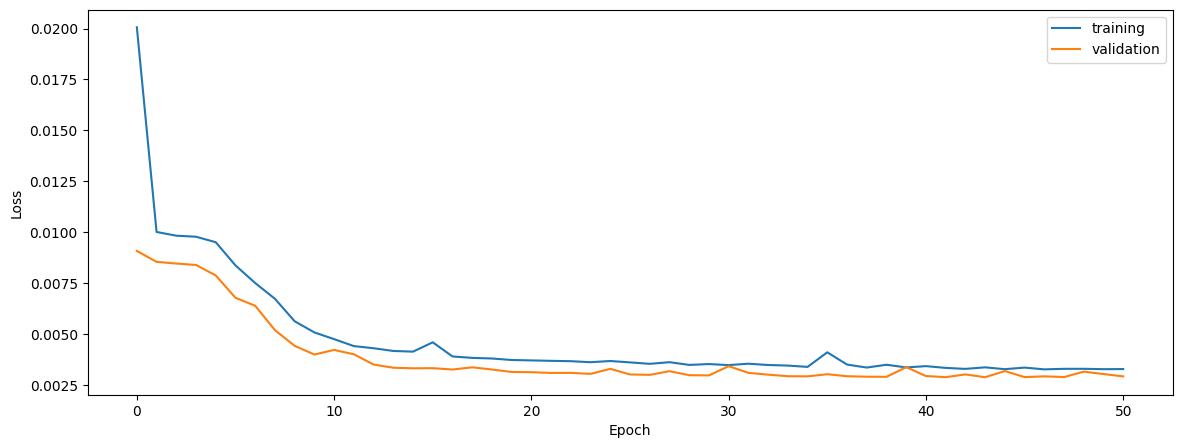

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8183373628829206
0.8134054716805538
0.7982995850750798


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8183373628829206
0.8134054716805538
0.7982995850750798


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8232879161033158
0.8212714233155797
0.8132358688462495


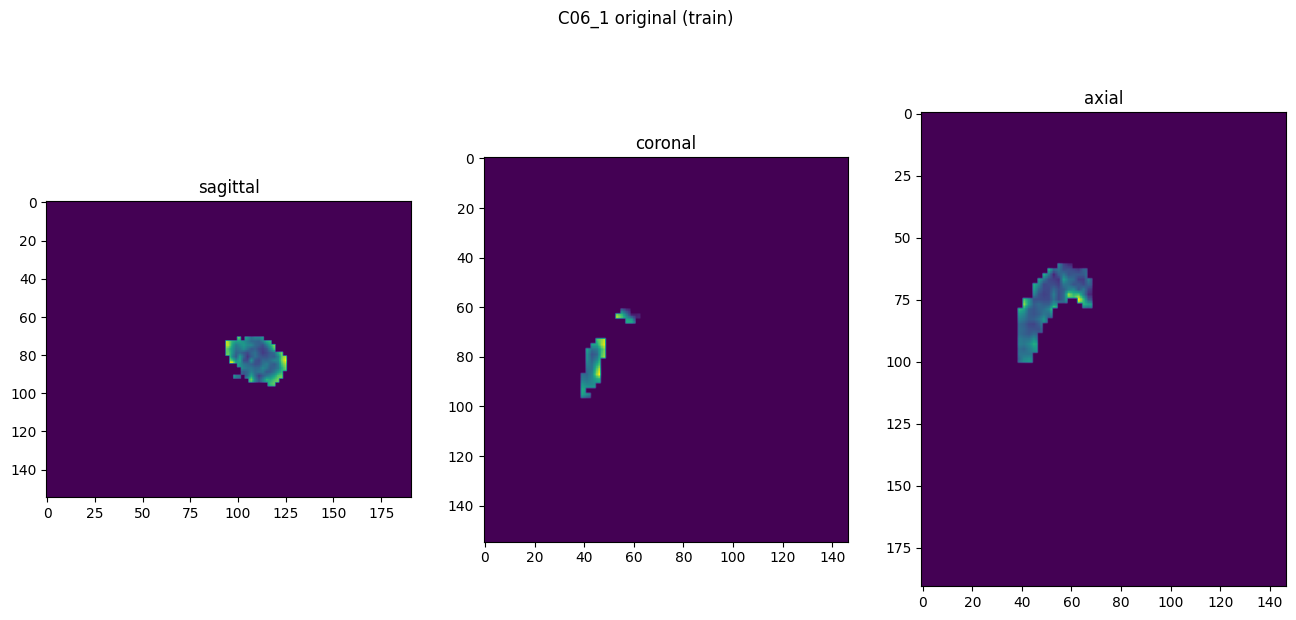

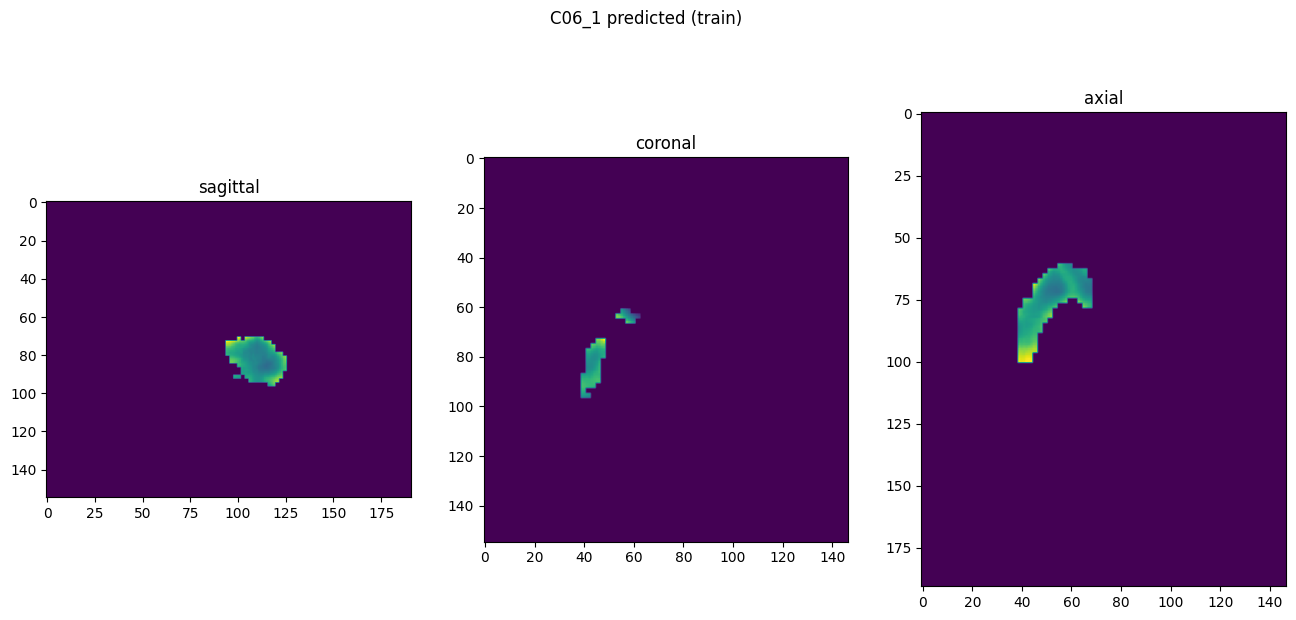

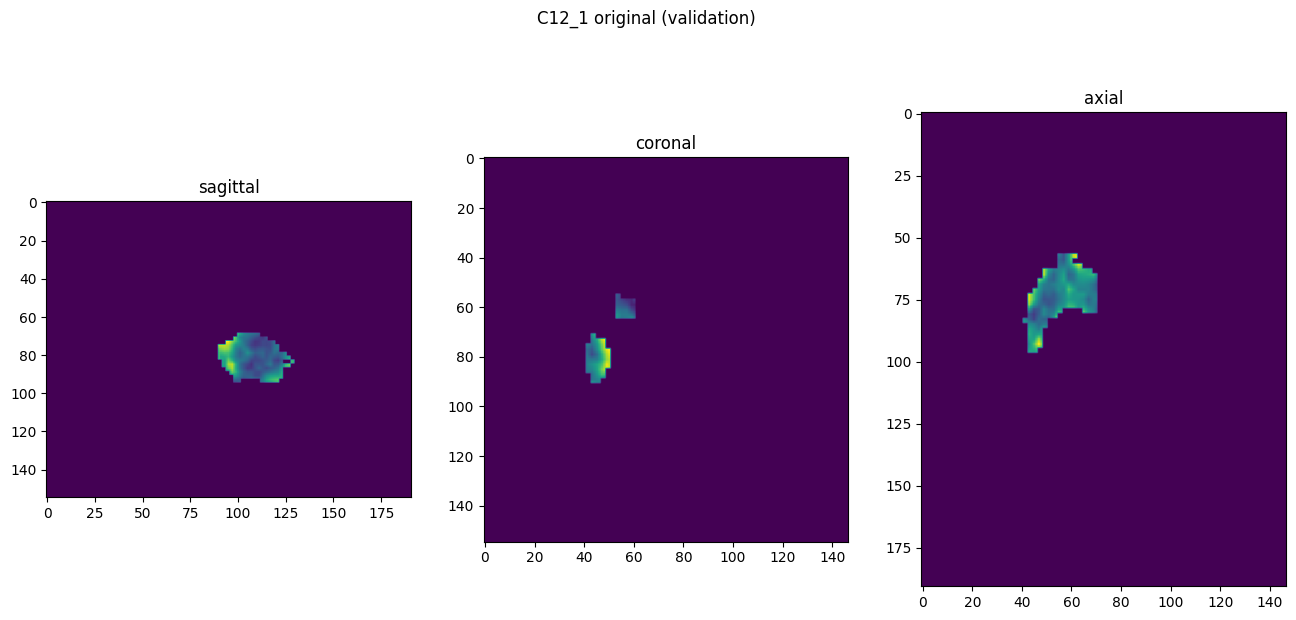

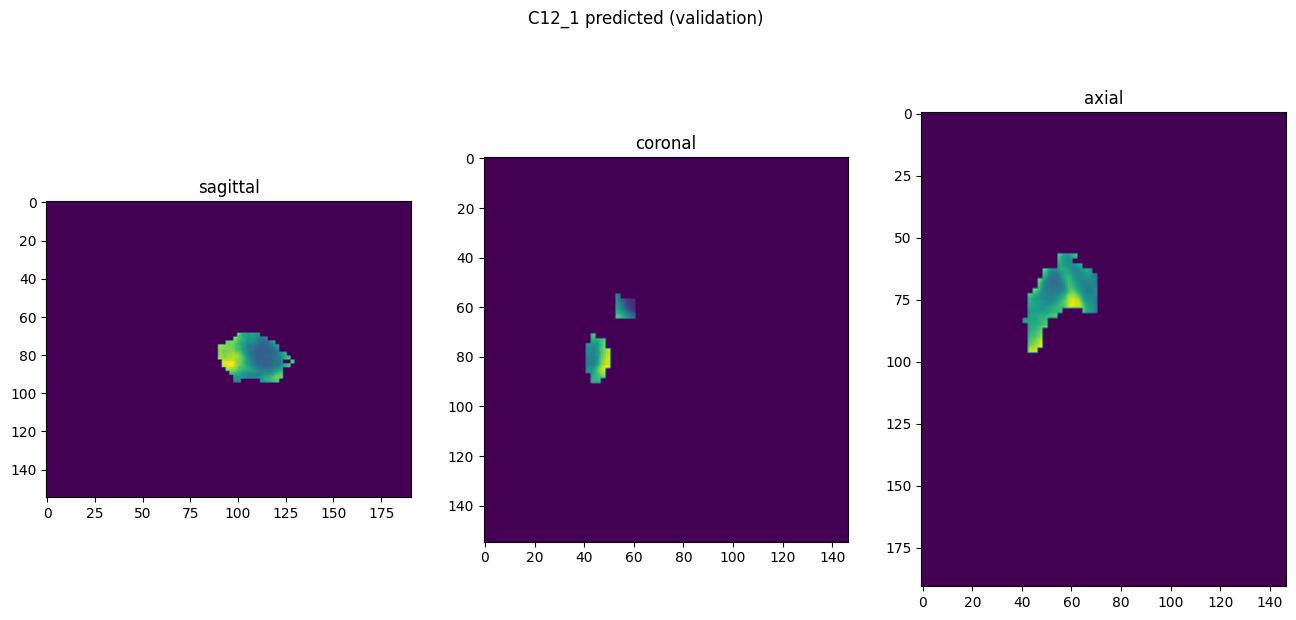

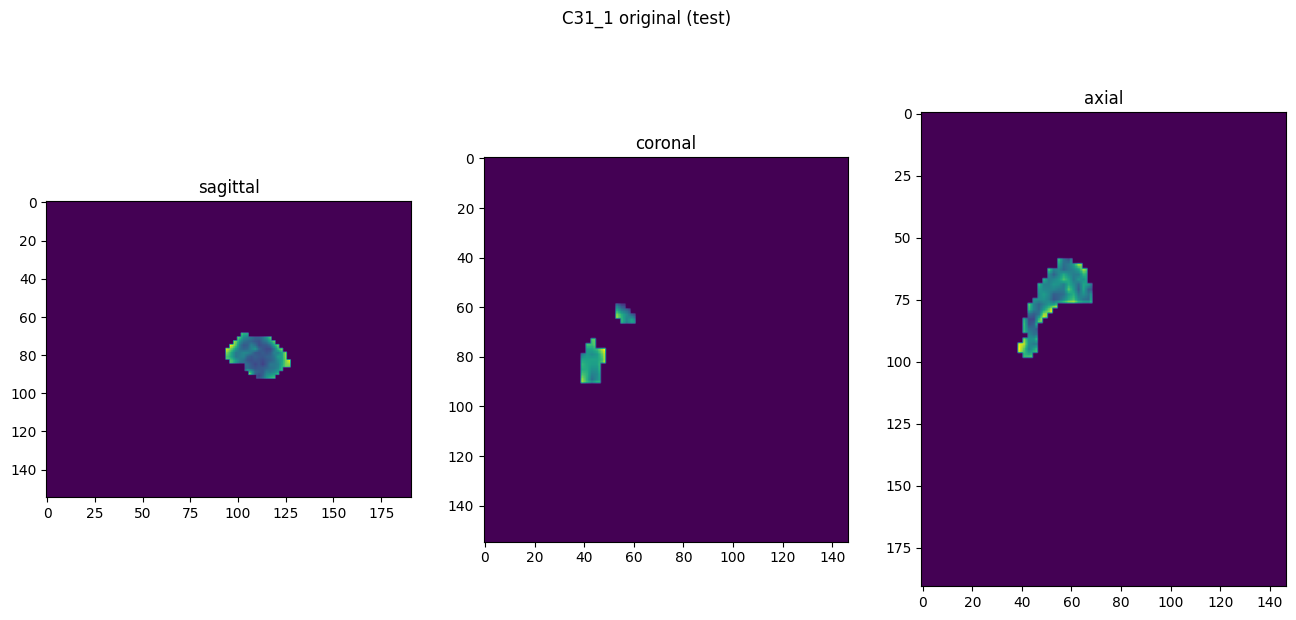

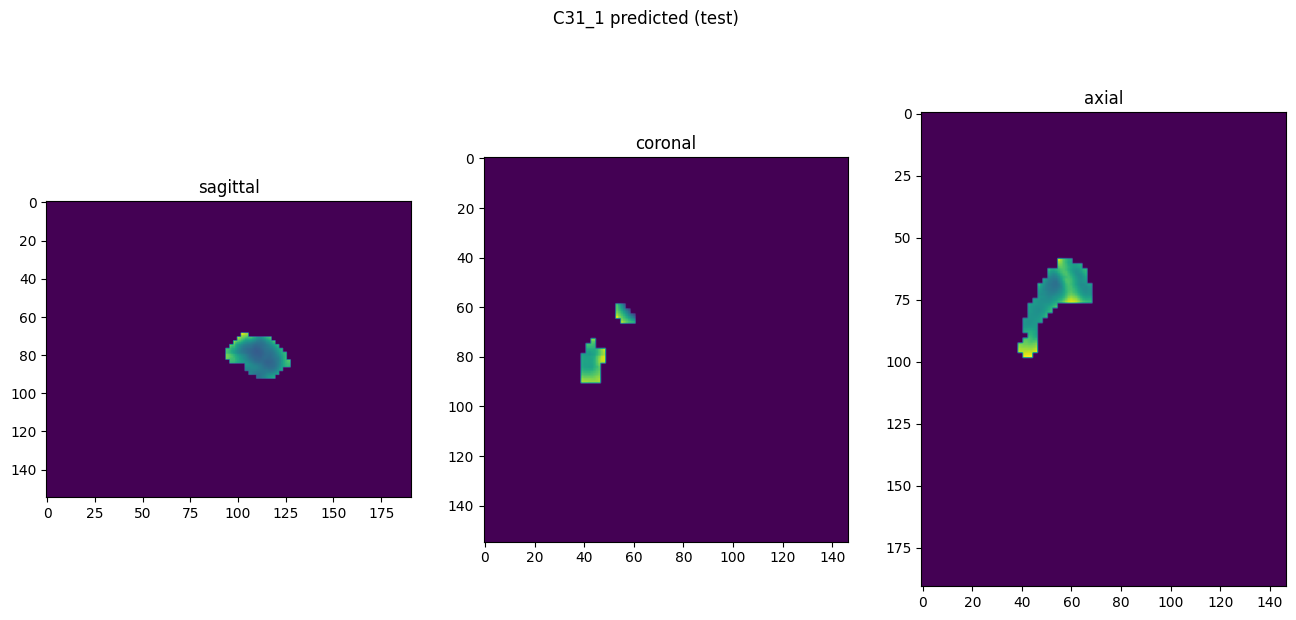

In [10]:
showResults(model, gen, threshold=None, background=False)